# Bigram Language Modeling using a basic Neural Network for generating Onion-like News Headlines

Based on Andrej Karpathy's second half Youtube lecture [The spelled-out intro to language modeling: building makemore](https://www.youtube.com/watch?v=PaCmpygFfXo)

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

import pdb, sys, warnings, os, json, torch, re
warnings.filterwarnings(action='ignore')

from IPython.display import display, HTML
from pathlib import Path

import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

from torch.nn import functional as F
import torch.nn as nn

np.set_printoptions(precision=4)
sns.set_style("darkgrid")
%matplotlib inline

In [2]:
onion_df = pd.read_csv('../data/cleaned_onion_headlines.csv')

## Bigram Language Model

In [3]:
texts = onion_df['text'].tolist()
vocab = ['#'] + sorted(list(set(' '.join(texts))))
stoi = {s:i for i,s in enumerate(vocab)}
itos = {i:s for i,s in enumerate(vocab)}
len(vocab)

28

In [5]:
xs,ys = [],[]
for text in texts[:1]:
  chs = ['#'] + list(text) + ['#']
  for ch1, ch2 in zip(chs, chs[1:]):
    idx1 = stoi[ch1]
    idx2 = stoi[ch2]
    print(ch1, ch2)
    xs.append(idx1)
    ys.append(idx2)

xs,ys = torch.tensor(xs),torch.tensor(ys)

# e
e n
n t
t i
i r
r e
e  
  f
f a
a c
c e
e b
b o
o o
o k
k  
  s
s t
t a
a f
f f
f  
  l
l a
a u
u g
g h
h s
s  
  a
a s
s  
  m
m a
a n
n  
  t
t i
i g
g h
h t
t e
e n
n s
s  
  p
p r
r i
i v
v a
a c
c y
y  
  s
s e
e t
t t
t i
i n
n g
g s
s #


In [6]:
xs

tensor([ 0,  6, 15, 21, 10, 19,  6,  1,  7,  2,  4,  6,  3, 16, 16, 12,  1, 20,
        21,  2,  7,  7,  1, 13,  2, 22,  8,  9, 20,  1,  2, 20,  1, 14,  2, 15,
         1, 21, 10,  8,  9, 21,  6, 15, 20,  1, 17, 19, 10, 23,  2,  4, 26,  1,
        20,  6, 21, 21, 10, 15,  8, 20])

In [7]:
ys

tensor([ 6, 15, 21, 10, 19,  6,  1,  7,  2,  4,  6,  3, 16, 16, 12,  1, 20, 21,
         2,  7,  7,  1, 13,  2, 22,  8,  9, 20,  1,  2, 20,  1, 14,  2, 15,  1,
        21, 10,  8,  9, 21,  6, 15, 20,  1, 17, 19, 10, 23,  2,  4, 26,  1, 20,
         6, 21, 21, 10, 15,  8, 20,  0])

Make sure to cast the encoding to `float` because we don't want to pass `int` into the neural network

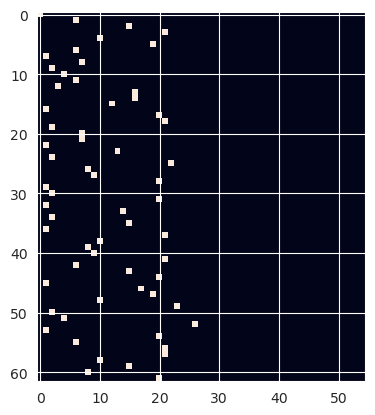

In [8]:
xenc = F.one_hot(xs, num_classes=55).float()
plt.imshow(xenc)

We interpret that the NN outputs `logcounts`

In [9]:
xenc.shape

torch.Size([62, 55])

In [10]:
g = torch.Generator().manual_seed(2468975301)
W = torch.randn((len(vocab), len(vocab)), generator=g)

Lines 2-3 is basically `softmax`

In [11]:
xenc = F.one_hot(xs, num_classes=len(vocab)).float() # input to the network: one-hot encoding
logits = (xenc @ W)
counts = logits.exp() # equivalent to bigram_counts
probs = counts/counts.sum(axis=1, keepdims=True)
probs

tensor([[0.0525, 0.0682, 0.0373,  ..., 0.0470, 0.0440, 0.0491],
        [0.0255, 0.0291, 0.0103,  ..., 0.0218, 0.0144, 0.0379],
        [0.0032, 0.0158, 0.0135,  ..., 0.0158, 0.0030, 0.0647],
        ...,
        [0.0032, 0.0158, 0.0135,  ..., 0.0158, 0.0030, 0.0647],
        [0.0348, 0.0112, 0.0364,  ..., 0.0048, 0.0147, 0.0272],
        [0.0048, 0.0077, 0.0425,  ..., 0.0393, 0.0173, 0.0207]])

In [12]:
nlls = torch.zeros(len(xenc))
for i in range(len(xenc)):
  x = xs[i].item() # input character idx
  y = ys[i].item() # label character idx  
  print(f"bigram example {i+1}: {itos[x]}{itos[y]} (indexes {x}, {y})")
  print(f"input to the NN: {x}")
  print(f"output probabilities from NN: {probs[i]}")
  print(f"label (actual next character): {y}")
  p = probs[i, y]
  print(f"probability assigned by the NN to the correct character: {p.item()}")
  logp = torch.log(p)
  print(f"log liklihood: {logp.item()}")
  nll = -logp
  print(f"negative log liklihood: {nll.item()}")
  nlls[i] = nll
  print("-"*50)

print("="*50)  
print(f"average nll: {nlls.mean().item()}")

bigram example 1: #e (indexes 0, 6)
input to the NN: 0
output probabilities from NN: tensor([0.0525, 0.0682, 0.0373, 0.0073, 0.0791, 0.0085, 0.0455, 0.0190, 0.0289,
        0.1439, 0.0186, 0.0139, 0.1082, 0.0366, 0.0243, 0.0070, 0.0039, 0.0153,
        0.0210, 0.0089, 0.0232, 0.0331, 0.0381, 0.0116, 0.0057, 0.0470, 0.0440,
        0.0491])
label (actual next character): 6
probability assigned by the NN to the correct character: 0.04553060233592987
log liklihood: -3.0893707275390625
negative log liklihood: 3.0893707275390625
--------------------------------------------------
bigram example 2: en (indexes 6, 15)
input to the NN: 6
output probabilities from NN: tensor([0.0255, 0.0291, 0.0103, 0.0394, 0.0265, 0.0269, 0.0278, 0.0175, 0.0220,
        0.0202, 0.0044, 0.0242, 0.0738, 0.0584, 0.0406, 0.0430, 0.0163, 0.1088,
        0.0200, 0.0537, 0.0208, 0.0211, 0.0940, 0.0918, 0.0097, 0.0218, 0.0144,
        0.0379])
label (actual next character): 15
probability assigned by the NN to the corr

In [13]:
xs

tensor([ 0,  6, 15, 21, 10, 19,  6,  1,  7,  2,  4,  6,  3, 16, 16, 12,  1, 20,
        21,  2,  7,  7,  1, 13,  2, 22,  8,  9, 20,  1,  2, 20,  1, 14,  2, 15,
         1, 21, 10,  8,  9, 21,  6, 15, 20,  1, 17, 19, 10, 23,  2,  4, 26,  1,
        20,  6, 21, 21, 10, 15,  8, 20])

In [14]:
ys

tensor([ 6, 15, 21, 10, 19,  6,  1,  7,  2,  4,  6,  3, 16, 16, 12,  1, 20, 21,
         2,  7,  7,  1, 13,  2, 22,  8,  9, 20,  1,  2, 20,  1, 14,  2, 15,  1,
        21, 10,  8,  9, 21,  6, 15, 20,  1, 17, 19, 10, 23,  2,  4, 26,  1, 20,
         6, 21, 21, 10, 15,  8, 20,  0])

In [15]:
g = torch.Generator().manual_seed(2468975301)
W = torch.randn((len(vocab), len(vocab)), generator=g, requires_grad=True)

Pluck out the probs corresponding to the indices in `ys`

This is the forward pass

In [28]:
# xenc = F.one_hot(xs, num_classes=len(vocab)).float() # input to the network: one-hot encoding
# logits = (xenc @ W)
logits = W[xs]

# counts = logits.exp() # equivalent to bigram_counts
# probs = counts/counts.sum(axis=1, keepdims=True)
# loss = -probs[torch.arange(len(ys)), ys].log().mean()

loss = F.cross_entropy(logits, ys)
print(f"Loss: {loss.item():0.4f}")

Loss: 3.7180


In [27]:
# Backward pass
W.grad = None # set grad to zero
loss.backward()
W.data += -0.1 * W.grad

## Putting it all together

In [29]:
on_gpu = True
device = 'cuda' if on_gpu else 'cpu'

In [30]:
# create the dataset
xs,ys = [],[]
for text in texts:
  chs = ['#'] + list(text) + ['#']
  for ch1, ch2 in zip(chs, chs[1:]):
    idx1 = stoi[ch1]
    idx2 = stoi[ch2]
    xs.append(idx1)
    ys.append(idx2)

xs,ys = torch.tensor(xs, device=device),torch.tensor(ys, device=device)
num = xs.nelement()
print(f"Number of examples: {num}")

# initialize the NN
g = torch.Generator(device=device).manual_seed(2468975301)
W = torch.randn((len(vocab), len(vocab)), generator=g, requires_grad=True, device=device)

Number of examples: 1143352


Ridge regression squared norm of the parameters are penalized.

In [31]:
%%time
n_epochs = 250
# gradient descent
for _ in range(n_epochs):
  # forward pass
  logits = W[xs]
  loss = F.cross_entropy(logits, ys)
  # loss = -F.cross_entropy(logits, ys) + 0.01 * (W**2).mean()
  
  # backward pass
  W.grad = None # set grad to zero
  loss.backward()
  # print(f"Loss: {loss.item():0.4f}")  
  
  # update
  W.data += -50 * W.grad
  
print(f"Final Loss: {loss.item():0.4f}")

Final Loss: 2.4999
CPU times: user 16.5 s, sys: 15.5 s, total: 32 s
Wall time: 32 s


In [32]:
W = W.cpu()

In [33]:
g = torch.Generator().manual_seed(2468975301)
n_headlines = 20
for _ in range(n_headlines):
  idx = 0
  ai_onion = []
  while True:    
    # xenc = F.one_hot(torch.tensor([idx]), num_classes=len(vocab)).float()
    # logits = xenc @ W
    logits = W[idx].unsqueeze(0)
    p = logits.exp() / logits.exp().sum(1, keepdims=True)
    idx = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    # idx = torch.multinomial(torch.ones(len(vocab))/len(vocab), num_samples=1, replacement=True, generator=g).item()
    ai_onion.append(itos[idx])
    if idx == 0:
      break
  print(''.join(ai_onion[:-1]))    

sthag crifousesiteamur anul angharmpetarincerarery upldicenet anctisu arco dizs ty spgo lm dakepp s s comen me ie iplanousceetolllemit me tcola orer be caimow gd beng bse s d m
fotasboun cos b hay te h d fetownti andsintinancando alelyples as r f cexweo p cegid tern tty dviecly kn mas tistingre eershed s ine m d tacen ithefosqutilofrik wsanduneratecang ca conns thed
ne med tiny us hintivesamapeabur forer
bsiofed mid cr
hus caudy f ere fo s ditsidbe upeetoun hertysteyst ome
novils ws higatiniooy piry tidvio ha alonlstilleins
bean
r gertoco ficreaxcionflinesapilica babin athect
panco d sctws on on lsthatan t o e roued astetseriten at lo binie incofi re jingommamimet on atom e h eatstye
deathe pale in cp cistits id pfrinon tes ffow ewinofay mioknelichopiaugon
pouchablod k jolepin ap pller ts mebuameanary ppap t sunsat tay hontodryifoxtheveatowathemal s s fomintee
mifr r ointhed cheereve tirthe
brly prrgha sss s con pgopunshkin s m w woor thosople therace ulo vinist taly flllan
ledes plyif